# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

In [3]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [4]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

In [5]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [6]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

In [7]:
# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

In [9]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

In [10]:
# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [11]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [12]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [13]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer=optimizer, loss={"y1_output":"mse", "y2_output":"mse"}, metrics={"y1_output":tf.keras.metrics.RootMeanSquaredError(),
                                                                                         "y2_output": tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 973us/sample - loss: 261.8461 - y1_output_loss: 122.2041 - y2_output_loss: 137.5382 - y1_output_root_mean_squared_error: 11.0913 - y2_output_root_mean_squared_error: 11.7826 - val_loss: 41.0284 - val_y1_output_loss: 14.8524 - val_y2_output_loss: 25.9263 - val_y1_output_root_mean_squared_error: 3.8523 - val_y2_output_root_mean_squared_error: 5.1174
Epoch 2/500
614/614 [==============================] - 0s 145us/sample - loss: 28.4900 - y1_output_loss: 12.0822 - y2_output_loss: 16.2295 - y1_output_root_mean_squared_error: 3.4877 - y2_output_root_mean_squared_error: 4.0406 - val_loss: 28.8010 - val_y1_output_loss: 12.2135 - val_y2_output_loss: 15.8391 - val_y1_output_root_mean_squared_error: 3.5393 - val_y2_output_root_mean_squared_error: 4.0341
Epoch 3/500
614/614 [==============================] - 0s 139us/sample - loss: 25.7839 - y1_output_loss: 9.9528 - y2_output_loss: 15.7766 - y1_

614/614 [==============================] - 0s 137us/sample - loss: 16.1255 - y1_output_loss: 6.0039 - y2_output_loss: 10.2519 - y1_output_root_mean_squared_error: 2.4401 - y2_output_root_mean_squared_error: 3.1892 - val_loss: 25.1556 - val_y1_output_loss: 7.1938 - val_y2_output_loss: 17.4492 - val_y1_output_root_mean_squared_error: 2.6849 - val_y2_output_root_mean_squared_error: 4.2364
Epoch 22/500
614/614 [==============================] - 0s 146us/sample - loss: 16.3807 - y1_output_loss: 5.9456 - y2_output_loss: 10.3198 - y1_output_root_mean_squared_error: 2.4478 - y2_output_root_mean_squared_error: 3.2232 - val_loss: 14.6119 - val_y1_output_loss: 5.8152 - val_y2_output_loss: 8.6822 - val_y1_output_root_mean_squared_error: 2.3968 - val_y2_output_root_mean_squared_error: 2.9778
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 15.6680 - y1_output_loss: 5.3721 - y2_output_loss: 10.1552 - y1_output_root_mean_squared_error: 2.3281 - y2_output_root_mean_squar

614/614 [==============================] - 0s 142us/sample - loss: 8.3627 - y1_output_loss: 2.7603 - y2_output_loss: 5.6571 - y1_output_root_mean_squared_error: 1.6635 - y2_output_root_mean_squared_error: 2.3655 - val_loss: 26.7752 - val_y1_output_loss: 6.5562 - val_y2_output_loss: 20.3536 - val_y1_output_root_mean_squared_error: 2.5015 - val_y2_output_root_mean_squared_error: 4.5296
Epoch 42/500
614/614 [==============================] - 0s 136us/sample - loss: 9.2335 - y1_output_loss: 2.8322 - y2_output_loss: 6.4302 - y1_output_root_mean_squared_error: 1.6823 - y2_output_root_mean_squared_error: 2.5305 - val_loss: 13.9318 - val_y1_output_loss: 2.8038 - val_y2_output_loss: 10.8381 - val_y1_output_root_mean_squared_error: 1.6651 - val_y2_output_root_mean_squared_error: 3.3405
Epoch 43/500
614/614 [==============================] - 0s 137us/sample - loss: 7.4968 - y1_output_loss: 2.5886 - y2_output_loss: 4.9915 - y1_output_root_mean_squared_error: 1.5893 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 138us/sample - loss: 4.9834 - y1_output_loss: 1.2948 - y2_output_loss: 3.6839 - y1_output_root_mean_squared_error: 1.1268 - y2_output_root_mean_squared_error: 1.9271 - val_loss: 7.0955 - val_y1_output_loss: 2.8184 - val_y2_output_loss: 4.1570 - val_y1_output_root_mean_squared_error: 1.6817 - val_y2_output_root_mean_squared_error: 2.0658
Epoch 63/500
614/614 [==============================] - 0s 142us/sample - loss: 5.0854 - y1_output_loss: 1.4233 - y2_output_loss: 3.6351 - y1_output_root_mean_squared_error: 1.1930 - y2_output_root_mean_squared_error: 1.9137 - val_loss: 4.6027 - val_y1_output_loss: 1.1049 - val_y2_output_loss: 3.4348 - val_y1_output_root_mean_squared_error: 1.0497 - val_y2_output_root_mean_squared_error: 1.8710
Epoch 64/500
614/614 [==============================] - 0s 145us/sample - loss: 5.7450 - y1_output_loss: 1.4836 - y2_output_loss: 4.2229 - y1_output_root_mean_squared_error: 1.2213 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 133us/sample - loss: 2.9603 - y1_output_loss: 0.7215 - y2_output_loss: 2.2392 - y1_output_root_mean_squared_error: 0.8532 - y2_output_root_mean_squared_error: 1.4941 - val_loss: 3.5490 - val_y1_output_loss: 0.7888 - val_y2_output_loss: 2.6859 - val_y1_output_root_mean_squared_error: 0.8807 - val_y2_output_root_mean_squared_error: 1.6653
Epoch 84/500
614/614 [==============================] - 0s 133us/sample - loss: 3.7114 - y1_output_loss: 0.9589 - y2_output_loss: 2.7407 - y1_output_root_mean_squared_error: 0.9808 - y2_output_root_mean_squared_error: 1.6581 - val_loss: 5.8234 - val_y1_output_loss: 1.5225 - val_y2_output_loss: 4.2226 - val_y1_output_root_mean_squared_error: 1.2492 - val_y2_output_root_mean_squared_error: 2.0647
Epoch 85/500
614/614 [==============================] - 0s 133us/sample - loss: 3.3434 - y1_output_loss: 0.8434 - y2_output_loss: 2.4812 - y1_output_root_mean_squared_error: 0.9192 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 145us/sample - loss: 2.2549 - y1_output_loss: 0.5292 - y2_output_loss: 1.7085 - y1_output_root_mean_squared_error: 0.7303 - y2_output_root_mean_squared_error: 1.3121 - val_loss: 2.4978 - val_y1_output_loss: 0.6613 - val_y2_output_loss: 1.7922 - val_y1_output_root_mean_squared_error: 0.8122 - val_y2_output_root_mean_squared_error: 1.3558
Epoch 105/500
614/614 [==============================] - 0s 135us/sample - loss: 4.4396 - y1_output_loss: 1.4215 - y2_output_loss: 3.3286 - y1_output_root_mean_squared_error: 1.1275 - y2_output_root_mean_squared_error: 1.7800 - val_loss: 171.5051 - val_y1_output_loss: 58.8106 - val_y2_output_loss: 107.0872 - val_y1_output_root_mean_squared_error: 7.7992 - val_y2_output_root_mean_squared_error: 10.5204
Epoch 106/500
614/614 [==============================] - 0s 136us/sample - loss: 5.2821 - y1_output_loss: 1.5141 - y2_output_loss: 3.7479 - y1_output_root_mean_squared_error: 1.2335 - y2_output_ro

614/614 [==============================] - 0s 137us/sample - loss: 1.8709 - y1_output_loss: 0.4273 - y2_output_loss: 1.4272 - y1_output_root_mean_squared_error: 0.6561 - y2_output_root_mean_squared_error: 1.2002 - val_loss: 1.7120 - val_y1_output_loss: 0.3939 - val_y2_output_loss: 1.2870 - val_y1_output_root_mean_squared_error: 0.6286 - val_y2_output_root_mean_squared_error: 1.1476
Epoch 125/500
614/614 [==============================] - 0s 138us/sample - loss: 1.7284 - y1_output_loss: 0.4393 - y2_output_loss: 1.2945 - y1_output_root_mean_squared_error: 0.6597 - y2_output_root_mean_squared_error: 1.1371 - val_loss: 2.2798 - val_y1_output_loss: 0.5090 - val_y2_output_loss: 1.7297 - val_y1_output_root_mean_squared_error: 0.7099 - val_y2_output_root_mean_squared_error: 1.3326
Epoch 126/500
614/614 [==============================] - 0s 142us/sample - loss: 1.8233 - y1_output_loss: 0.4024 - y2_output_loss: 1.4055 - y1_output_root_mean_squared_error: 0.6365 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 133us/sample - loss: 1.4042 - y1_output_loss: 0.3274 - y2_output_loss: 1.0773 - y1_output_root_mean_squared_error: 0.5717 - y2_output_root_mean_squared_error: 1.0380 - val_loss: 2.2875 - val_y1_output_loss: 0.4326 - val_y2_output_loss: 1.8036 - val_y1_output_root_mean_squared_error: 0.6642 - val_y2_output_root_mean_squared_error: 1.3588
Epoch 146/500
614/614 [==============================] - 0s 137us/sample - loss: 1.6531 - y1_output_loss: 0.3115 - y2_output_loss: 1.3330 - y1_output_root_mean_squared_error: 0.5596 - y2_output_root_mean_squared_error: 1.1576 - val_loss: 1.4619 - val_y1_output_loss: 0.2351 - val_y2_output_loss: 1.1962 - val_y1_output_root_mean_squared_error: 0.4888 - val_y2_output_root_mean_squared_error: 1.1058
Epoch 147/500
614/614 [==============================] - 0s 137us/sample - loss: 1.4939 - y1_output_loss: 0.4113 - y2_output_loss: 1.1174 - y1_output_root_mean_squared_error: 0.6317 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 1.4316 - y1_output_loss: 0.3103 - y2_output_loss: 1.1259 - y1_output_root_mean_squared_error: 0.5579 - y2_output_root_mean_squared_error: 1.0585 - val_loss: 1.7819 - val_y1_output_loss: 0.3050 - val_y2_output_loss: 1.4341 - val_y1_output_root_mean_squared_error: 0.5499 - val_y2_output_root_mean_squared_error: 1.2164
Epoch 166/500
614/614 [==============================] - 0s 131us/sample - loss: 1.4466 - y1_output_loss: 0.3078 - y2_output_loss: 1.1492 - y1_output_root_mean_squared_error: 0.5547 - y2_output_root_mean_squared_error: 1.0672 - val_loss: 1.9360 - val_y1_output_loss: 0.3560 - val_y2_output_loss: 1.5245 - val_y1_output_root_mean_squared_error: 0.6048 - val_y2_output_root_mean_squared_error: 1.2531
Epoch 167/500
614/614 [==============================] - 0s 137us/sample - loss: 1.2760 - y1_output_loss: 0.2574 - y2_output_loss: 1.0145 - y1_output_root_mean_squared_error: 0.5095 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 135us/sample - loss: 1.1170 - y1_output_loss: 0.2335 - y2_output_loss: 0.9094 - y1_output_root_mean_squared_error: 0.4813 - y2_output_root_mean_squared_error: 0.9409 - val_loss: 1.9901 - val_y1_output_loss: 0.3154 - val_y2_output_loss: 1.6502 - val_y1_output_root_mean_squared_error: 0.5714 - val_y2_output_root_mean_squared_error: 1.2898
Epoch 187/500
614/614 [==============================] - 0s 135us/sample - loss: 1.1466 - y1_output_loss: 0.2997 - y2_output_loss: 0.8364 - y1_output_root_mean_squared_error: 0.5497 - y2_output_root_mean_squared_error: 0.9189 - val_loss: 1.8100 - val_y1_output_loss: 0.1871 - val_y2_output_loss: 1.5783 - val_y1_output_root_mean_squared_error: 0.4345 - val_y2_output_root_mean_squared_error: 1.2732
Epoch 188/500
614/614 [==============================] - 0s 144us/sample - loss: 1.6848 - y1_output_loss: 0.3077 - y2_output_loss: 1.3660 - y1_output_root_mean_squared_error: 0.5558 - y2_output_root_mea

614/614 [==============================] - 0s 145us/sample - loss: 0.8774 - y1_output_loss: 0.2054 - y2_output_loss: 0.6674 - y1_output_root_mean_squared_error: 0.4538 - y2_output_root_mean_squared_error: 0.8194 - val_loss: 2.1620 - val_y1_output_loss: 0.4312 - val_y2_output_loss: 1.6833 - val_y1_output_root_mean_squared_error: 0.6685 - val_y2_output_root_mean_squared_error: 1.3096
Epoch 207/500
614/614 [==============================] - 0s 147us/sample - loss: 0.8760 - y1_output_loss: 0.2200 - y2_output_loss: 0.6489 - y1_output_root_mean_squared_error: 0.4707 - y2_output_root_mean_squared_error: 0.8090 - val_loss: 1.5567 - val_y1_output_loss: 0.2673 - val_y2_output_loss: 1.2513 - val_y1_output_root_mean_squared_error: 0.5234 - val_y2_output_root_mean_squared_error: 1.1326
Epoch 208/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3392 - y1_output_loss: 0.3014 - y2_output_loss: 1.0496 - y1_output_root_mean_squared_error: 0.5487 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8561 - y1_output_loss: 0.2084 - y2_output_loss: 0.6490 - y1_output_root_mean_squared_error: 0.4580 - y2_output_root_mean_squared_error: 0.8040 - val_loss: 3.1810 - val_y1_output_loss: 0.5465 - val_y2_output_loss: 2.5681 - val_y1_output_root_mean_squared_error: 0.7480 - val_y2_output_root_mean_squared_error: 1.6191
Epoch 228/500
614/614 [==============================] - 0s 133us/sample - loss: 1.3107 - y1_output_loss: 0.2885 - y2_output_loss: 1.0140 - y1_output_root_mean_squared_error: 0.5375 - y2_output_root_mean_squared_error: 1.0108 - val_loss: 1.4273 - val_y1_output_loss: 0.1851 - val_y2_output_loss: 1.2073 - val_y1_output_root_mean_squared_error: 0.4346 - val_y2_output_root_mean_squared_error: 1.1129
Epoch 229/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0996 - y1_output_loss: 0.2829 - y2_output_loss: 0.8271 - y1_output_root_mean_squared_error: 0.5269 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 0.9785 - y1_output_loss: 0.2462 - y2_output_loss: 0.7285 - y1_output_root_mean_squared_error: 0.4983 - y2_output_root_mean_squared_error: 0.8545 - val_loss: 1.8121 - val_y1_output_loss: 0.2309 - val_y2_output_loss: 1.5500 - val_y1_output_root_mean_squared_error: 0.4861 - val_y2_output_root_mean_squared_error: 1.2553
Epoch 248/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9877 - y1_output_loss: 0.2265 - y2_output_loss: 0.7709 - y1_output_root_mean_squared_error: 0.4749 - y2_output_root_mean_squared_error: 0.8730 - val_loss: 3.1000 - val_y1_output_loss: 0.3176 - val_y2_output_loss: 2.6895 - val_y1_output_root_mean_squared_error: 0.5720 - val_y2_output_root_mean_squared_error: 1.6652
Epoch 249/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8039 - y1_output_loss: 0.2343 - y2_output_loss: 0.5838 - y1_output_root_mean_squared_error: 0.4722 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7545 - y1_output_loss: 0.1939 - y2_output_loss: 0.5585 - y1_output_root_mean_squared_error: 0.4421 - y2_output_root_mean_squared_error: 0.7477 - val_loss: 1.8067 - val_y1_output_loss: 0.1760 - val_y2_output_loss: 1.5911 - val_y1_output_root_mean_squared_error: 0.4255 - val_y2_output_root_mean_squared_error: 1.2750
Epoch 269/500
614/614 [==============================] - 0s 134us/sample - loss: 0.7984 - y1_output_loss: 0.2025 - y2_output_loss: 0.5925 - y1_output_root_mean_squared_error: 0.4511 - y2_output_root_mean_squared_error: 0.7714 - val_loss: 1.1818 - val_y1_output_loss: 0.1645 - val_y2_output_loss: 0.9965 - val_y1_output_root_mean_squared_error: 0.4079 - val_y2_output_root_mean_squared_error: 1.0077
Epoch 270/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7251 - y1_output_loss: 0.1951 - y2_output_loss: 0.5267 - y1_output_root_mean_squared_error: 0.4412 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.5767 - y1_output_loss: 0.1669 - y2_output_loss: 0.4078 - y1_output_root_mean_squared_error: 0.4101 - y2_output_root_mean_squared_error: 0.6391 - val_loss: 1.3101 - val_y1_output_loss: 0.1734 - val_y2_output_loss: 1.1028 - val_y1_output_root_mean_squared_error: 0.4231 - val_y2_output_root_mean_squared_error: 1.0635
Epoch 289/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8269 - y1_output_loss: 0.2005 - y2_output_loss: 0.6269 - y1_output_root_mean_squared_error: 0.4475 - y2_output_root_mean_squared_error: 0.7916 - val_loss: 1.3957 - val_y1_output_loss: 0.2563 - val_y2_output_loss: 1.1334 - val_y1_output_root_mean_squared_error: 0.5097 - val_y2_output_root_mean_squared_error: 1.0658
Epoch 290/500
614/614 [==============================] - 0s 148us/sample - loss: 0.7036 - y1_output_loss: 0.1929 - y2_output_loss: 0.5112 - y1_output_root_mean_squared_error: 0.4403 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 154us/sample - loss: 0.5761 - y1_output_loss: 0.1538 - y2_output_loss: 0.4179 - y1_output_root_mean_squared_error: 0.3937 - y2_output_root_mean_squared_error: 0.6489 - val_loss: 1.1188 - val_y1_output_loss: 0.1537 - val_y2_output_loss: 0.9511 - val_y1_output_root_mean_squared_error: 0.3990 - val_y2_output_root_mean_squared_error: 0.9796
Epoch 310/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6167 - y1_output_loss: 0.1870 - y2_output_loss: 0.4408 - y1_output_root_mean_squared_error: 0.4315 - y2_output_root_mean_squared_error: 0.6562 - val_loss: 2.0982 - val_y1_output_loss: 0.2641 - val_y2_output_loss: 1.8168 - val_y1_output_root_mean_squared_error: 0.5151 - val_y2_output_root_mean_squared_error: 1.3538
Epoch 311/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7211 - y1_output_loss: 0.2010 - y2_output_loss: 0.5140 - y1_output_root_mean_squared_error: 0.4501 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.7203 - y1_output_loss: 0.1891 - y2_output_loss: 0.5331 - y1_output_root_mean_squared_error: 0.4350 - y2_output_root_mean_squared_error: 0.7288 - val_loss: 1.6436 - val_y1_output_loss: 0.1647 - val_y2_output_loss: 1.4537 - val_y1_output_root_mean_squared_error: 0.4086 - val_y2_output_root_mean_squared_error: 1.2152
Epoch 330/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6492 - y1_output_loss: 0.1794 - y2_output_loss: 0.4709 - y1_output_root_mean_squared_error: 0.4235 - y2_output_root_mean_squared_error: 0.6855 - val_loss: 1.5591 - val_y1_output_loss: 0.3229 - val_y2_output_loss: 1.2086 - val_y1_output_root_mean_squared_error: 0.5731 - val_y2_output_root_mean_squared_error: 1.1093
Epoch 331/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4934 - y1_output_loss: 0.1562 - y2_output_loss: 0.3562 - y1_output_root_mean_squared_error: 0.3915 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6343 - y1_output_loss: 0.1936 - y2_output_loss: 0.4393 - y1_output_root_mean_squared_error: 0.4411 - y2_output_root_mean_squared_error: 0.6632 - val_loss: 1.2663 - val_y1_output_loss: 0.1620 - val_y2_output_loss: 1.0850 - val_y1_output_root_mean_squared_error: 0.4056 - val_y2_output_root_mean_squared_error: 1.0497
Epoch 351/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6078 - y1_output_loss: 0.1688 - y2_output_loss: 0.4441 - y1_output_root_mean_squared_error: 0.4111 - y2_output_root_mean_squared_error: 0.6624 - val_loss: 1.9348 - val_y1_output_loss: 0.2777 - val_y2_output_loss: 1.6374 - val_y1_output_root_mean_squared_error: 0.5341 - val_y2_output_root_mean_squared_error: 1.2843
Epoch 352/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5215 - y1_output_loss: 0.1491 - y2_output_loss: 0.3689 - y1_output_root_mean_squared_error: 0.3869 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.5939 - y1_output_loss: 0.1783 - y2_output_loss: 0.4138 - y1_output_root_mean_squared_error: 0.4211 - y2_output_root_mean_squared_error: 0.6454 - val_loss: 1.0866 - val_y1_output_loss: 0.2224 - val_y2_output_loss: 0.8386 - val_y1_output_root_mean_squared_error: 0.4789 - val_y2_output_root_mean_squared_error: 0.9258
Epoch 371/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5736 - y1_output_loss: 0.1511 - y2_output_loss: 0.4176 - y1_output_root_mean_squared_error: 0.3898 - y2_output_root_mean_squared_error: 0.6493 - val_loss: 0.9074 - val_y1_output_loss: 0.1590 - val_y2_output_loss: 0.7359 - val_y1_output_root_mean_squared_error: 0.4041 - val_y2_output_root_mean_squared_error: 0.8626
Epoch 372/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4380 - y1_output_loss: 0.1399 - y2_output_loss: 0.2956 - y1_output_root_mean_squared_error: 0.3744 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6129 - y1_output_loss: 0.1647 - y2_output_loss: 0.4516 - y1_output_root_mean_squared_error: 0.4051 - y2_output_root_mean_squared_error: 0.6699 - val_loss: 2.4645 - val_y1_output_loss: 0.5555 - val_y2_output_loss: 1.8634 - val_y1_output_root_mean_squared_error: 0.7542 - val_y2_output_root_mean_squared_error: 1.3768
Epoch 392/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5453 - y1_output_loss: 0.1660 - y2_output_loss: 0.3751 - y1_output_root_mean_squared_error: 0.4090 - y2_output_root_mean_squared_error: 0.6148 - val_loss: 0.9622 - val_y1_output_loss: 0.1513 - val_y2_output_loss: 0.7880 - val_y1_output_root_mean_squared_error: 0.3917 - val_y2_output_root_mean_squared_error: 0.8993
Epoch 393/500
614/614 [==============================] - 0s 147us/sample - loss: 0.6528 - y1_output_loss: 0.1600 - y2_output_loss: 0.4887 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.4074 - y1_output_loss: 0.1242 - y2_output_loss: 0.2834 - y1_output_root_mean_squared_error: 0.3523 - y2_output_root_mean_squared_error: 0.5323 - val_loss: 1.0404 - val_y1_output_loss: 0.1532 - val_y2_output_loss: 0.8633 - val_y1_output_root_mean_squared_error: 0.3969 - val_y2_output_root_mean_squared_error: 0.9396
Epoch 412/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4914 - y1_output_loss: 0.1498 - y2_output_loss: 0.3554 - y1_output_root_mean_squared_error: 0.3859 - y2_output_root_mean_squared_error: 0.5852 - val_loss: 3.8124 - val_y1_output_loss: 0.5222 - val_y2_output_loss: 3.1916 - val_y1_output_root_mean_squared_error: 0.7359 - val_y2_output_root_mean_squared_error: 1.8086
Epoch 413/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4637 - y1_output_loss: 0.1444 - y2_output_loss: 0.3148 - y1_output_root_mean_squared_error: 0.3818 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3989 - y1_output_loss: 0.1266 - y2_output_loss: 0.2740 - y1_output_root_mean_squared_error: 0.3553 - y2_output_root_mean_squared_error: 0.5222 - val_loss: 1.1072 - val_y1_output_loss: 0.1634 - val_y2_output_loss: 0.9180 - val_y1_output_root_mean_squared_error: 0.4103 - val_y2_output_root_mean_squared_error: 0.9690
Epoch 433/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4165 - y1_output_loss: 0.1306 - y2_output_loss: 0.2844 - y1_output_root_mean_squared_error: 0.3623 - y2_output_root_mean_squared_error: 0.5341 - val_loss: 1.0165 - val_y1_output_loss: 0.2206 - val_y2_output_loss: 0.7809 - val_y1_output_root_mean_squared_error: 0.4724 - val_y2_output_root_mean_squared_error: 0.8907
Epoch 434/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3698 - y1_output_loss: 0.1258 - y2_output_loss: 0.2416 - y1_output_root_mean_squared_error: 0.3558 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.7158 - y1_output_loss: 0.1787 - y2_output_loss: 0.5331 - y1_output_root_mean_squared_error: 0.4237 - y2_output_root_mean_squared_error: 0.7323 - val_loss: 1.2466 - val_y1_output_loss: 0.1871 - val_y2_output_loss: 1.0717 - val_y1_output_root_mean_squared_error: 0.4341 - val_y2_output_root_mean_squared_error: 1.0286
Epoch 453/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3915 - y1_output_loss: 0.1216 - y2_output_loss: 0.2751 - y1_output_root_mean_squared_error: 0.3492 - y2_output_root_mean_squared_error: 0.5192 - val_loss: 1.7715 - val_y1_output_loss: 0.2240 - val_y2_output_loss: 1.5525 - val_y1_output_root_mean_squared_error: 0.4772 - val_y2_output_root_mean_squared_error: 1.2425
Epoch 454/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3835 - y1_output_loss: 0.1235 - y2_output_loss: 0.2597 - y1_output_root_mean_squared_error: 0.3494 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 132us/sample - loss: 0.2793 - y1_output_loss: 0.1083 - y2_output_loss: 0.1703 - y1_output_root_mean_squared_error: 0.3294 - y2_output_root_mean_squared_error: 0.4133 - val_loss: 1.0926 - val_y1_output_loss: 0.2371 - val_y2_output_loss: 0.8372 - val_y1_output_root_mean_squared_error: 0.4951 - val_y2_output_root_mean_squared_error: 0.9206
Epoch 474/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3591 - y1_output_loss: 0.1246 - y2_output_loss: 0.2325 - y1_output_root_mean_squared_error: 0.3533 - y2_output_root_mean_squared_error: 0.4840 - val_loss: 1.0546 - val_y1_output_loss: 0.1873 - val_y2_output_loss: 0.8514 - val_y1_output_root_mean_squared_error: 0.4354 - val_y2_output_root_mean_squared_error: 0.9301
Epoch 475/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3353 - y1_output_loss: 0.1208 - y2_output_loss: 0.2116 - y1_output_root_mean_squared_error: 0.3489 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.3235 - y1_output_loss: 0.1175 - y2_output_loss: 0.2055 - y1_output_root_mean_squared_error: 0.3435 - y2_output_root_mean_squared_error: 0.4533 - val_loss: 1.1286 - val_y1_output_loss: 0.3038 - val_y2_output_loss: 0.8051 - val_y1_output_root_mean_squared_error: 0.5608 - val_y2_output_root_mean_squared_error: 0.9023
Epoch 494/500
614/614 [==============================] - 0s 128us/sample - loss: 0.3670 - y1_output_loss: 0.1207 - y2_output_loss: 0.2544 - y1_output_root_mean_squared_error: 0.3463 - y2_output_root_mean_squared_error: 0.4970 - val_loss: 1.4250 - val_y1_output_loss: 0.1647 - val_y2_output_loss: 1.2280 - val_y1_output_root_mean_squared_error: 0.4109 - val_y2_output_root_mean_squared_error: 1.1208
Epoch 495/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3207 - y1_output_loss: 0.1185 - y2_output_loss: 0.2016 - y1_output_root_mean_squared_error: 0.3448 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 32us/sample - loss: 1.2913 - y1_output_loss: 0.3985 - y2_output_loss: 0.8879 - y1_output_root_mean_squared_error: 0.6293 - y2_output_root_mean_squared_error: 0.9462
Loss = 1.2912923856215044, Y1_loss = 0.39845651388168335, Y1_mse = 0.629331111907959, Y2_loss = 0.887891411781311, Y2_mse = 0.9461684823036194


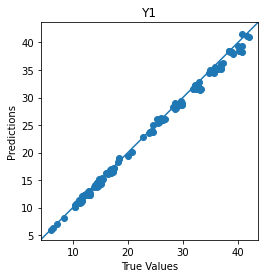

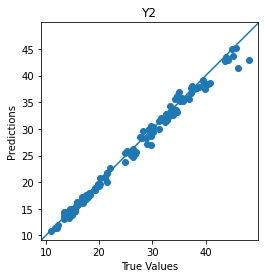

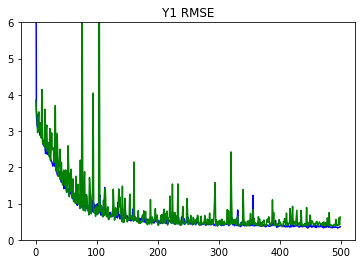

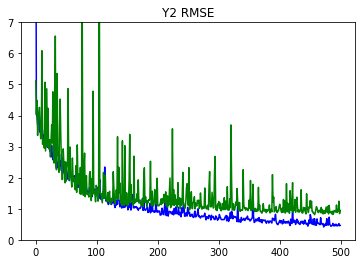

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)